<a href="https://colab.research.google.com/github/UthamanA/Appliances-energy-prediction-ML-Regression/blob/main/appliances_energy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Appliances Energy Prediction**


In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# Read data

file = ("/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/Appliances Energy Prediction/Data set/data_application_energy.csv")
df = pd.read_csv(file, parse_dates=['date'])

# Lowercase the column names
df.columns = [x.lower() for x in df.columns]

#df.isna().any()

# Set datetime index due to time series analysis 
df = df.set_index('date')

In this data set there are informations about the energy consumption of a house's appliances, temperature and humidity of house's rooms. In addition, there are data(temperature,pressure,humidity, visibility,windspeed and Tdewpoint) of weather conditions in the given area. The data set is at 10 min for about 4.5 months.

Our goal is to make appliances' energy load forecasting.

**1. Feature Engineering**

Check for outliers: We will consider as outliers the 0,1% top values of appliances' load because it is fact that recordings of power load higher than 800Wh from a house appliance are not logical. These may be false recordings caused by an instant fault on the recording devices. Additionally, in this data set there are not any NA values.

The number of the 0,1% top values of appliances' load is 19 and they have power load higher than 790 Wh.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


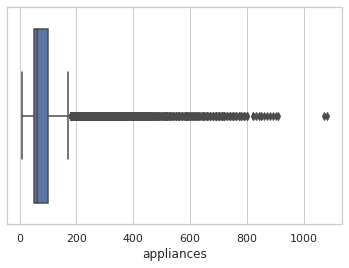

In [3]:
# Find outliers
sorted_appliances = df.sort_values('appliances',ascending=False)
print("The number of the 0,1% top values of appliances' load is",
      len(sorted_appliances.head(len(sorted_appliances)//1000)),"and they have power load higher than",
      sorted_appliances.appliances[19], "Wh.")

# boxplot appliances
sns.set(style="whitegrid")
ax = sns.boxplot(sorted_appliances.appliances)

In [4]:
df = df.dropna()
df = df.drop(df[(df.appliances>790)|(df.appliances<0)].index)

The idea is that appliances' load is hour, day, week, month dependent. It is logical assumption that in night hours the load is low or at weekends the energy consumption is higher than the weekdays because more people are at home.

Additionaly, it is expected a correlation between temperature/humidity and energy load. For instance, when someone cooks(higher consumption) probably the temperature in the kichen raises.

Moreover, we can use qualitative predictors to indicate if a mesured load is lower or higher in comparison to the average energy load a given time interval.

I will append several columns as new features to the original data, based on the above-mentioned assumptions and then i will find out which of them explain better appliances consumption.

In [5]:
# Append more columns to the DataFrame based on datetime
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['week'] = df.index.week


# # Adding the lag of the target variable from 1 steps back up to 7 (for arima model)

# for i in range(1, 8):
#     df["lag_{}".format(i)] = df.appliances.shift(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


In [7]:
#log appliances
df['log_appliances'] = np.log(df.appliances)

# Average house temperature and humidity
df['house_temp'] =(df.t1+df.t2+df.t3+df.t4+df.t5+df.t7+df.t8+df.t9)/8
df['house_hum'] =(df.rh_1+df.rh_2+df.rh_3+df.rh_4+df.rh_5+df.rh_7+df.rh_8+df.rh_9)/8


# Products of several features to remove additive assumption(An Introducton to Statistical learning p. 87,88)
df['hour*lights'] = df.hour * df.lights
df['t3rh3'] = df.t3 * df.rh_3
df['t2rh2'] = df.t2 * df.rh_2
df['t1rh1'] = df.t2 * df.rh_2
df['t5rh4'] = df.t2 * df.rh_2
df['t5rh5'] = df.t2 * df.rh_2
df['t6rh6'] = df.t2 * df.rh_2
df['t7rh7'] = df.t2 * df.rh_2
df['t8rh8'] = df.t2 * df.rh_2
df['t9rh9'] = df.t2 * df.rh_2

# Calculate average energy load per weekday and hour
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

# Average energy consumption per weekday and hour
df['weekday_avg'] = list(map(
    code_mean(df[:], 'weekday', "appliances").get, df.weekday))
df['hour_avg'] = list(map(
    code_mean(df[:], 'hour', "appliances").get, df.hour))

We will use smaller data sets in 30 minitues and 1 hour basis instead of 10 minutes to reduce noice.

In [8]:
# Data sets in 30 minitues and 1 hour basis

df_hour = df.resample('1H').mean()
df_30min =df.resample('30min').mean()

In [9]:
# Qualitative predictors 
'''We assume that we have low(high) energy load when the appliances consumption is lower(higher) 
   than a given point of the hourly average counsumption. This point is dependent of data time frequency 
   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.
'''

df['low_consum'] = (df.appliances+25<(df.hour_avg))*1
df['high_consum'] = (df.appliances+100>(df.hour_avg))*1

df_hour['low_consum'] = (df_hour.appliances+25<(df_hour.hour_avg))*1
df_hour['high_consum'] = (df_hour.appliances+25>(df_hour.hour_avg))*1

df_30min['low_consum'] = (df_30min.appliances+25<(df_30min.hour_avg))*1
df_30min['high_consum'] = (df_30min.appliances+35>(df_30min.hour_avg))*1

Below several graphs are plotted to examine the aforementioned assumptions.

Text(0, 0.5, 'Appliances consumption in Wh')

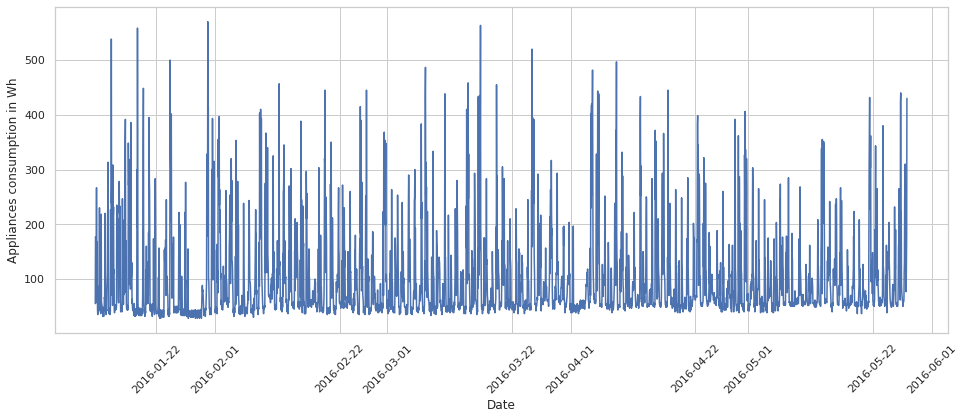

In [10]:
plt.figure(figsize=(16,6))
plt.plot(df_hour.appliances)
plt.xticks( rotation='45')
plt.xlabel('Date')
plt.ylabel('Appliances consumption in Wh')

In this plot things are not very clear, thus it is suggested to use grooup-bys.

In [11]:
# Functions to be used from the plots

def daily(x,df=df):
    return df.groupby('weekday')[x].mean()
def hourly(x,df=df):
    return df.groupby('hour')[x].mean()

def monthly_daily(x,df=df):
    by_day = df.pivot_table(index='weekday', 
                                columns=['month'],
                                values=x,
                                aggfunc='mean')
    return round(by_day, ndigits=2)

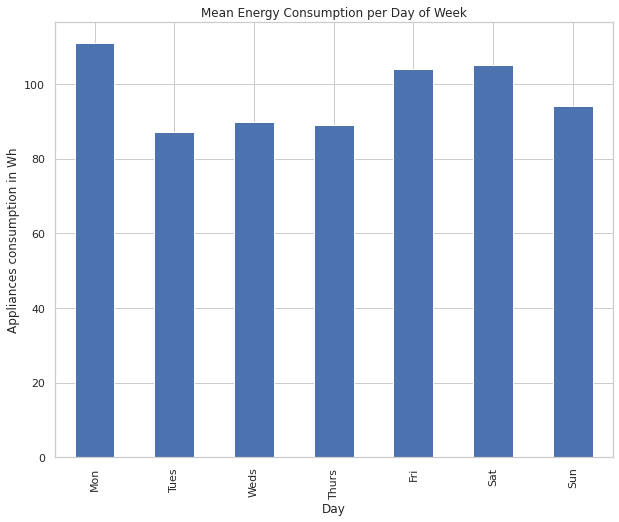

In [12]:
# Plot of Mean Energy Consumption per Day of Week

daily('appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

The power load is a bit higher on Monday ,Friday, Saturday and Sunday than the other days.